In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_pickle("./Preprocessed/Preprocessed_Data.pkl")
data.head(5)

,Summary,Precip Type,Temperature (C),Humidity,Visibility (km),Daily Summary,Month,Apparent Temperature (C)
0,0.685536,-0.354531,-0.257951,0.792748,1.309107,1.201254,-0.728497,7.388889
1,0.685536,-0.354531,-0.270141,0.639470,1.309107,1.201254,-0.728497,7.227778
2,0.226376,-0.354531,-0.267819,0.792748,1.100806,1.201254,-0.728497,9.377778
3,0.685536,-0.354531,-0.381594,0.486192,1.309107,1.201254,-0.728497,5.944444
4,0.226376,-0.354531,-0.332833,0.486192,1.309107,1.201254,-0.728497,6.977778


In [3]:
x=data.iloc[:,:-1].values
y=data.iloc[:,-1].values

In [4]:
y

array([ 7.38888889,  7.22777778,  9.37777778, ..., 22.03888889,
       21.52222222, 20.43888889])

In [5]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest= train_test_split(x,y,test_size=0.3,random_state=1)

In [6]:
xtest.shape

(28781, 7)

## 1. Inherently Interpretabale ML model

We will use Graphviz library to show decision tree that is constructed and how models make certain decisons

In [7]:
from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor() # using default parameters only
dt.fit(xtrain,ytrain)

DecisionTreeRegressor()

### Method 1: Using Graphviz Library - Model Specific Technique

In [8]:
col_names= list(data.columns)
col_names.pop()
col_names

['Summary',
 'Precip Type',
 'Temperature (C)',
 'Humidity',
 'Visibility (km)',
 'Daily Summary',
 'Month']

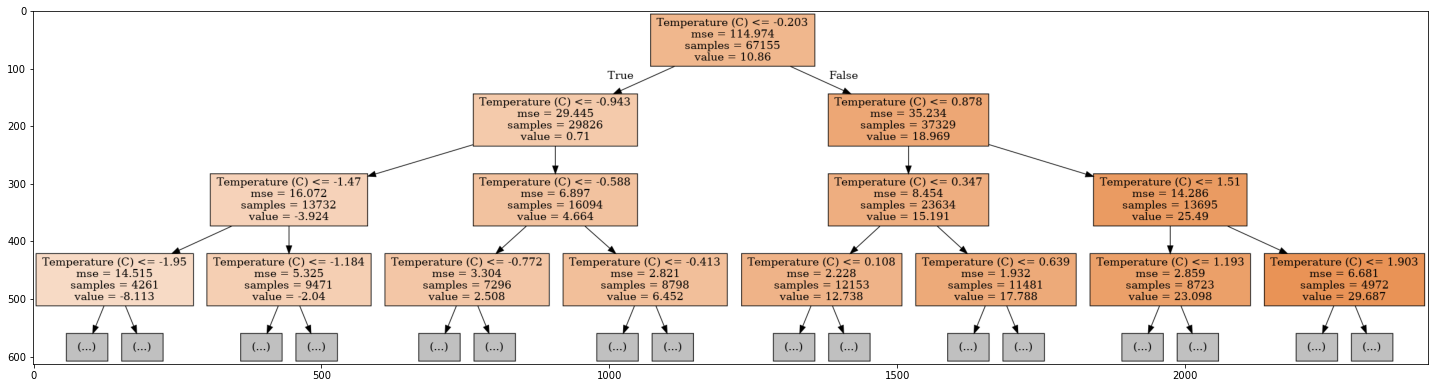

In [9]:
from sklearn import tree
# Visualising the decision tree
decision_tree = tree.export_graphviz(dt, out_file='tree.dot', feature_names=col_names, filled=True, max_depth=3)

# converting the dot image to png format
!dot -Tpng tree.dot -o tree.png

#plotting the decision tree
image = plt.imread('tree.png')
plt.figure(figsize=(25,25))
plt.imshow(image)

### Method 2: Using sklearn's plot tree - Model Specific Technique

<Figure size 3600x3600 with 0 Axes>

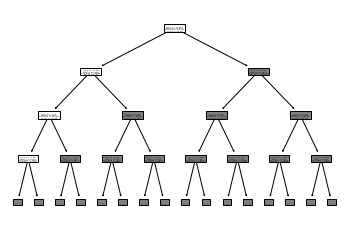

<Figure size 3600x3600 with 0 Axes>

In [10]:
tree.plot_tree(dt, max_depth=3)
plt.figure(figsize=(50,50)) # not clearly visible how splits are being made

### 2. Global Surrogate Method - Model agnostic technique

#### Example 1: Decision Tree as a surrogate model for Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

In [12]:
rf = RandomForestRegressor(n_estimators = 120)
rf.fit(xtrain,ytrain)

RandomForestRegressor(n_estimators=120)

In [13]:
ypred_rf=rf.predict(xtrain)

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
# Checking how correctly our model predicted
rmse=mean_squared_error(ytrain,ypred_rf)
r2=r2_score(ytrain,ypred_rf)
print("Mean Squared Error :",rmse)
print("r2:",r2)

Mean Squared Error : 0.11329085486954162
r2: 0.9990146399207643


In [15]:
# Now, for surrogate model, we will use the predictions of this model
dt_Surrogate = DecisionTreeRegressor( random_state=10)
dt_Surrogate.fit(xtrain,ypred_rf)# train on predictions of the previous model

DecisionTreeRegressor(random_state=10)

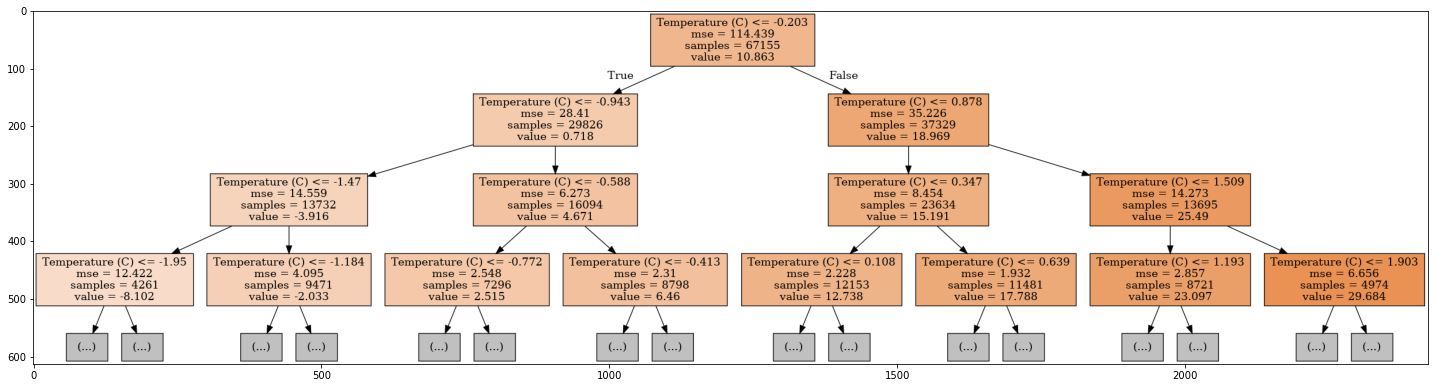

In [16]:
decision_tree = tree.export_graphviz(dt_Surrogate, out_file='tree2.dot', feature_names=col_names, filled=True, max_depth=3)

# converting the dot image to png format
!dot -Tpng tree2.dot -o tree2.png

#plotting the decision tree
image_rf = plt.imread('tree2.png')
plt.figure(figsize=(25,25))
plt.imshow(image_rf)

In [17]:
ypred_dtSurrogate=dt_Surrogate.predict(xtrain)

In [18]:
# Checking how closely this decision tree represents random forest
rmse_rf_dtSurrogate=mean_squared_error(ypred_rf,ypred_dtSurrogate)
print("Mean Squared Error :",rmse_rf_dtSurrogate)

Mean Squared Error : 3.57557333852594e-29


In [19]:
# The above value shows that the ppredictions are quite close to each other


#### Example 2: Decision tree as a Surrogate for Gradient Boosting Regressor

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
gb=GradientBoostingRegressor(n_estimators=120,random_state=0)
gb.fit(xtrain,ytrain)
ypred_gb=gb.predict(xtrain)

In [21]:
# Now, for surrogate model, we will use the predictions of this model
dt_Surrogate2 = DecisionTreeRegressor( random_state=10)
dt_Surrogate2.fit(xtrain,ypred_gb)# train on predictions of the previous model

DecisionTreeRegressor(random_state=10)

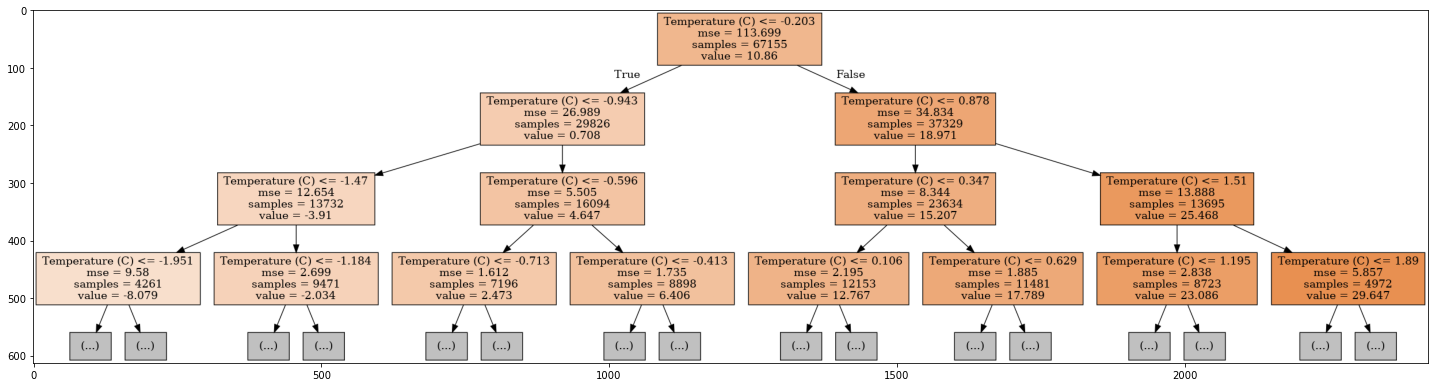

In [22]:
decision_tree = tree.export_graphviz(dt_Surrogate2, out_file='tree3.dot', feature_names=col_names, filled=True, max_depth=3)

# converting the dot image to png format
!dot -Tpng tree3.dot -o tree3.png

#plotting the decision tree
image_gb = plt.imread('tree3.png')
plt.figure(figsize=(25,25))
plt.imshow(image_gb)

## Using LIME to generate local interpretations

In [23]:
! pip install lime

In [24]:
from lime.lime_tabular import LimeTabularExplainer
# We canm use the random forest model trained above
# Creating Explainer function
featureNames= list(data.columns)
explainer = LimeTabularExplainer(xtrain, mode="regression", feature_names=featureNames)

In [25]:
xtest[10,:]

array([-0.92152435,  2.82062711, -1.31036178,  1.15039597, -2.0237165 ,
       -1.28775168, -1.59818542])

In [26]:
# Explaining 10th observation from test set
i = 10
# explanation using the random forest model
explanation = explainer.explain_instance(xtest[i,:], rf.predict)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.5615659161792148


In [27]:
# The prediction above is -3.55. The features shown in blue had a negative impact on our result and the features shown in orange had a positive impact.
result=rf.predict([xtest[10,:]])
result

array([-3.78244444])